In [1]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split, Subset
from torchvision import datasets, transforms, models
import os
from torch import device

In [3]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define image transformations (preprocessing for CNN)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pretrained models
])

In [6]:
horizontal_flip_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
vertical_flip_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
random_rotatation_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomRotation(degrees=25), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [7]:
# Set up dataset and dataloaders
# Assuming images are organized in folders: 'root_folder/class1/', 'root_folder/class2/', etc.
data_dir = './test_set/maps/'  # Path to your image folder
train_data_1 = datasets.ImageFolder(root=data_dir, transform=horizontal_flip_transform)
train_data_2 = datasets.ImageFolder(root=data_dir, transform=vertical_flip_transform)
train_data_3 = datasets.ImageFolder(root=data_dir, transform=random_rotatation_transform)
train_data_4 = datasets.ImageFolder(root=data_dir, transform=transform)
augmented_dataset = ConcatDataset([train_data_1, train_data_2, train_data_3, train_data_4])
train_size = int(0.7 * len(augmented_dataset))
val_size = int(0.2 * len(augmented_dataset))
test_size = len(augmented_dataset) - (train_size + val_size)
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(augmented_dataset, [train_size, val_size, test_size], generator=generator1)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# Create the model
model = nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, stride=2),  #(224-3)/2 + 1 = 111, out>>>111*111*8
                      nn.BatchNorm2d(8),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=1),     #(111-2)/1 + 1 = 110, out>>>110*110*8
                      nn.Conv2d(8, 32, kernel_size=3, padding=1),  #(110-3+2)/1 + 1 = 110, out>>>110*110*32
                      nn.BatchNorm2d(32),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2, stride=1),    #(110-2)/1 + 1 = 109, out>>>109*109*32
                      nn.Conv2d(32, 128, kernel_size=3, padding=1),  #(109-3+2)/1 + 1 = 109, out>>>109*109*128
                      nn.BatchNorm2d(128),
                      nn.Flatten(),  #109*109*128= 1520768
                      nn.ReLU(),
                      nn.Linear(1520768, 16),
                      nn.BatchNorm1d(16),
                      #nn.LayerNorm(16),
                      nn.ReLU(),
                      nn.Linear(16, 4)).to(device)


# Setup the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
criterion = nn.CrossEntropyLoss()
model.to(device)

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 24372292


In [ ]:
%%time
num_epochs = 25

best_val_loss = float('inf')
patience = 5
counter = 0

# Store the results for each fold
fold_results = []

# Track performance for this fold
fold_train_loss = []
fold_train_accuracy = []
fold_val_loss = []
fold_val_accuracy = []


for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    fold_train_loss.append(train_loss)
    fold_train_accuracy.append(train_accuracy)

    # Validation loop for this fold
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradients during validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss = running_val_loss / len(test_loader)
    val_accuracy = correct / total * 100
    fold_val_loss.append(val_loss)
    fold_val_accuracy.append(val_accuracy)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'cnn_gasteiger_1.pth')
        print('The best model was saved.')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

In [ ]:
# Plot Training and Validation Loss/Accuracy
epochs = range(1, 10 + 1)

plt.figure(figsize=(12, 6))
# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, fold_train_loss, label="Training Loss", marker="o")
plt.plot(epochs, fold_val_loss, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, fold_train_accuracy, label="Training Accuracy", marker="o")
plt.plot(epochs, fold_val_accuracy, label="Validation Accuracy", marker="o")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

print("Fine-tuning complete!")

In [ ]:
#To load the saved weights into the model architecture:
model.load_state_dict(torch.load("./cnn_gasteiger.pth")) 

In [17]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, 100 * train_acc

def train_model(model, loader, optimizer, n_epochs, device= device):
    losses, accuracies = np.empty(n_epochs), np.empty(n_epochs)
    loss_fn = nn.CrossEntropyLoss()
    for i in (pbar := trange(n_epochs)):
        loss, acc = train_epoch(model, loader, loss_fn, optimizer, device)
        losses[i], accuracies[i] = loss, acc
        pbar.set_description(f'Loss: {loss:.3f} | Accuracy: {acc:.2f}% ')
    return losses, accuracies

In [18]:
def test_model(model, loader):
    model.eval()
    acc = 0.
    y_test, y_prediction =[], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            pred = logits.argmax(dim=1)
            acc += (pred == labels).sum().item()
            y_test.extend(labels.cpu().numpy())
            y_prediction.extend(pred.cpu().numpy())
    size = len(loader.dataset)
    acc = 100 * acc / size
    print(f'Test accuracy on {size} test samples is {acc:.2f}%')
    return y_test, y_prediction

In [ ]:
# Train the model
results = train_model(model, train_loader, optimizer, n_epochs=10)

# Plot the loss curve and accuracies
plot_results(*results)

In [19]:
class_names = {0: 'AA', 1: 'AI', 2: 'IA', 3: 'II'}
kept_classes = [0, 1, 2, 3]

In [20]:
def plot_confusion_matrix(y_true, y_pred, class_names, kept_classes):
    dim = len(kept_classes)
    labels = [class_names[i] for i in kept_classes]
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    norm_conf_mat = conf_mat / np.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(dim), labels, rotation=45)
    plt.yticks(range(dim), labels)
    plt.colorbar()
    # Put number of each cell in plot
    for i in range(dim):
        for j in range(dim):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()

Test accuracy on 350 test samples is 67.43%


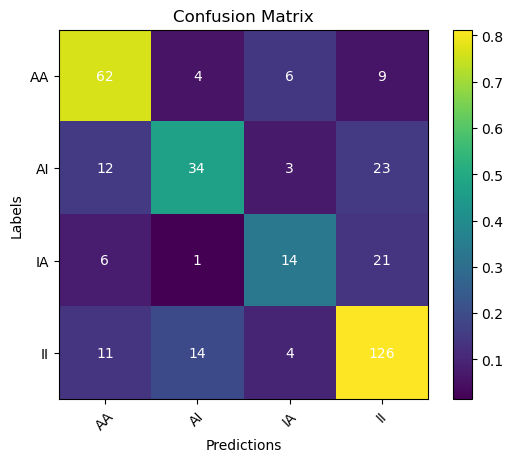

In [21]:
# Test the model
y_test, y_pred = test_model(model, test_loader)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, kept_classes)

In [22]:
from sklearn.metrics import classification_report

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.77      0.72        81
           1       0.64      0.47      0.54        72
           2       0.52      0.33      0.41        42
           3       0.70      0.81      0.75       155

    accuracy                           0.67       350
   macro avg       0.64      0.60      0.61       350
weighted avg       0.66      0.67      0.66       350



In [25]:
# Switch the model to evaluation mode
model.eval()  # Set model to evaluation mode
running_loss = 0.0
correct = 0
total = 0

# Disable gradient calculation for validation/testing
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print test statistics
test_loss = running_loss / len(test_loader)
test_accuracy = correct / total * 100
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.8944, Test Accuracy: 67.60%
